In [ ]:
#https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt

# Lecture6 AIC、多重共線性、AICをつかった変数選択の例

参考：[pythonのstatsmodelsを使った重回帰分析で溶解度予測：AICによるモデル選択](https://future-chem.com/esol-reg-aic/)

データの準備

データは、化学論文の化合物の溶解度予測で餅られているデータを使って、AIC、多重共線性、AICを使った変数選択（モデル選択）の例を示します。

データはSMILESと呼ばれるテキスト形式で示された分子構造（図）から、あらかじめ特量を計算したものを準備しています。

データセットの引用元であるEstimated SOLubility（ESOL）の論文では，

- clogP
- 分子量：MW
- 回転可能結合数：RB
- 芳香族指数：AP
- 非炭素原子数の比：NC
- 水素結合ドナー数：HD
- 水素結合アクセプター数：HA
- 極性表面積：PSA
  
の8つの記述子を用いて重回帰分析を行い，「各パラメータの重要さをt値の絶対値によって評価」することで最初の4つの記述子に絞り込み，最終的に以下の回帰式を得ています．

In [4]:
# 1. ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

<AxesSubplot:>

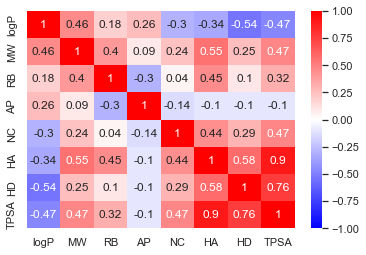

In [5]:
from sklearn.model_selection import train_test_split

df=pd.read_csv('data/ESOL_paper.csv')
X_train, X_test, y_train, y_test = train_test_split(df[['logP', 'MW', 'RB', 'AP', 'NC', 'HA', 'HD', 'TPSA']],
                                                   df.m_sol, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((858, 8), (286, 8), (858,), (286,))
fig = plt.figure()
sns.heatmap(data=X_train.corr().round(2), annot=True, vmax=1, vmin=-1, cmap='bwr')

## statsmodelsを用いたモデルの作成

### FULLモデルの作成

8個全ての記述子をモデル作成に使用してみましょう．statsmodelsではデータが全て同一のpandasデータフレーム中にあることが前提となっていますので，まずX_trainとy_trainをまとめて1つのデータフレームにしています．

In [6]:
X_y_train = X_train.join(y_train)
full_model = smf.ols('m_sol ~ logP + MW + RB + AP + NC + HA + HD + TPSA', data=X_y_train).fit()
full_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1206,0.100,1.202,0.230,-0.076,0.318
logP,-0.7835,0.053,-14.822,0.000,-0.887,-0.680
MW,-0.0063,0.001,-7.069,0.000,-0.008,-0.005
RB,0.0160,0.018,0.890,0.374,-0.019,0.051
AP,-0.2721,0.115,-2.365,0.018,-0.498,-0.046
NC,1.1567,0.236,4.894,0.000,0.693,1.621
HA,0.2031,0.046,4.447,0.000,0.113,0.293
HD,-0.0546,0.054,-1.012,0.312,-0.160,0.051
TPSA,-0.0158,0.003,-5.363,0.000,-0.022,-0.010


表中のt値やp値の意味は，「記述子の係数がゼロであるモデル（帰無仮説）」に対して，係数がゼロではない確率をt検定した値になります．つまりp値が低ければモデルに意味のある情報を加えている記述子と理解してよいです．

### ESOLモデルの作成
「logP」「MW」「RB」「AP」の４つの記述子を用いたモデルの作成もしてみましょう．

In [7]:
esol_model = smf.ols('m_sol ~ logP + MW + RB + AP', data=X_y_train).fit()
print(esol_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  m_sol   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     700.0
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          1.25e-267
Time:                        07:27:53   Log-Likelihood:                -1229.1
No. Observations:                 858   AIC:                             2468.
Df Residuals:                     853   BIC:                             2492.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2109      0.085      2.493      0.0

今回も乱数の種を同じに設定したため，全く同じ式が得られました．



### 多重共線性（multicollinearity）

多重共線性とは，説明変数間で相関係数が高い場合に生じる現象です．相関の高い複数の変数は同じような情報を持っているため，作成したモデルにおける係数の大小や符号などの解釈が難しくなってしまいます．一般的には相関係数が0.8を超える場合には注意が必要と言われています．先ほどの調べたようにPTSAとHAの相関係数が0.9でしたので，注意が必要そうです．

#### 分散拡大要因（VIF：Variance Inflation Factor）

独立変数間の相関係数行列の逆行列の対角要素を分散拡大要因（VIF）と呼び，多重共線性の存在をチェックするために使われます．VIFが10を超える独立変数は，多重共線性の原因となる可能性が高く，モデル構築の際には除去する方が好ましいと言われます

In [8]:
corr_mat = np.array(X_train.corr())
inv_corr_mat = np.linalg.inv(corr_mat)
pd.Series(np.diag(inv_corr_mat), index=X_train.columns)

logP     9.185386
MW       7.814513
RB       2.046585
AP       1.405224
NC       1.495421
HA       8.925479
HD       3.408831
TPSA    10.326682
dtype: float64

TPSAのVIFが10を超えているため，モデル構築の際には取り除くほうがよさそうです．

### 赤池情報量規準：AIC

は「赤池情報量規準（AIC：Akaike’s Information Criterion）」と呼ばれるものを用いてモデル選択を行っていこうと思います．類似の多数ありますが，AICが最もよく使われます．

AICは

AIC=−2×(最大対数尤度–推定されたパラメータ数）
で表される指標で，AICが小さいほど「よい」モデルとみなされます．尤度はパラメータ数を増やすと大きくなりやすいため，用いるパラメータ数に罰則をつけています．そのため不必要なパラメータが含まれていないモデルが選ばれやすいと言えます．

In [10]:
esol_model.aic

2468.238796040314

## statsmodelsを用いた重回帰分析

### 全探索

今回の場合はTPSAを除くと記述子の数が7個ですので，全ての組み合わせを考えて最も小さいAICを与えるモデルを選択することが現実的です．pythonで組み合わせを考える場合にはitertools.combinationsを用いるのが便利です．下記のコードでは

- generate_formulas関数で記述子の組合せから作成するモデルのformulaを生成
- modeling_linear関数でformulaに従ってモデルを作成
- 記述子ゼロのNullモデルを別個作成，評価
- for文中で利用する記述しを変化させながらモデルを作成，評価
- AICの値でソート

という順番で処理をしています．

In [11]:
desc_list = ['logP', 'MW', 'RB', 'AP', 'NC', 'HA', 'HD']

def generate_formulas(descriptors, num):
    import itertools
    if num > len(descriptors):
        return None
    else:
        for f in itertools.combinations(descriptors, num):
            formula = 'm_sol ~ ' + ' + '.join(f)
            yield formula

def modeling_linear(formula, data):
    model = smf.ols(formula=formula, data=data).fit()
    return formula, model

n_var = []
formula = []
model = []
AIC = []
adj_r2 = []
## Nullモデル作成
null_model = smf.ols(formula='m_sol ~ 1', data=X_y_train).fit()
n_var.append(0)
formula.append('m_sol ~ 1')
model.append(null_model)
AIC.append(null_model.aic)
adj_r2.append(null_model.rsquared_adj)
## 利用する記述子の数を変えながらモデル作成
for i in range(1,9):
    for f in generate_formulas(desc_list, i):
        eq, m = modeling_linear(formula=f, data=X_y_train)
        n_var.append(i)
        formula.append(f)
        model.append(m)
        AIC.append(m.aic)
        adj_r2.append(m.rsquared_adj)

df_model = pd.DataFrame({'n_var': n_var,
                        'formula': formula,
                        'model': model,
                        'aic': AIC,
                        'adj_r2': adj_r2})
## AIC評価で上位5つ
df_model.aic.sort_values()[:5]
df_model.formula[df_model.aic.sort_values()[:5].index]
print(df_model.model[df_model.aic.idxmin()].summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0857      0.101      0.850      0.396      -0.112       0.284
logP          -0.6995      0.047    -14.783      0.000      -0.792      -0.607
MW            -0.0076      0.001     -8.799      0.000      -0.009      -0.006
AP            -0.3739      0.103     -3.639      0.000      -0.576      -0.172
NC             0.9648      0.236      4.084      0.000       0.501       1.428
HA             0.0749      0.031      2.381      0.018       0.013       0.137
HD            -0.1798      0.049     -3.675      0.000      -0.276      -0.084


In [12]:
df_model.aic.sort_values()[:5]

124    2427.719766
127    2429.333483
121    2430.013110
106    2431.414490
103    2434.607337
Name: aic, dtype: float64

In [13]:
df_model.formula[df_model.aic.sort_values()[:5].index]

124         m_sol ~ logP + MW + AP + NC + HA + HD
127    m_sol ~ logP + MW + RB + AP + NC + HA + HD
121         m_sol ~ logP + MW + RB + AP + NC + HD
106              m_sol ~ logP + MW + AP + NC + HD
103              m_sol ~ logP + MW + RB + NC + HD
Name: formula, dtype: object

これより，「logP」「MW」「AP」「NC」「HA」「HD」の6つを用いたモデルが最もAICが低かったようです．P値の値も大丈夫そうです．

### ステップワイズ法（stepwise regression）

ステップワイズ法では全ての変数を組み入れたFullモデルを作成し，そこから1つの変数を取り除いたモデルを作成します（今回は7種類）．もっともAICの低いモデルを採用し，変数6個のモデルとします．そこからまた1つの変数を取り除いたモデルを作成し，，，と繰り返し改善が見られなくなった点で探索を終了します．逆に変数０のNullモデルから出発し，１つずつ変数を足していくステップワイズ法も考えられます．

今回はFullモデルから始めるステップワイズ法を，R言語のstepAIC関数に類似したpython関数として実装します．

In [14]:
def stepAIC(descs_l):
    import copy
    descriptors = descs_l
    f_model = smf.ols(formula='m_sol ~ ' + ' + '.join(descriptors), data=X_y_train).fit()
    best_aic = f_model.aic
    best_model = f_model
    while descriptors:
        desc_selected = ''
        flag = 0
        for desk in descriptors:
            used_desks = copy.deepcopy(descriptors)
            used_desks.remove(desk)
            formula = 'm_sol ~ ' + ' + '.join(used_desks)
            model = smf.ols(formula=formula, data=X_y_train).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                desc_selected = desk
                flag = 1
        if flag:
            descriptors.remove(desc_selected)
        else:
            break
    return best_model

model_a = stepAIC(desc_list)
print(model_a.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0857      0.101      0.850      0.396      -0.112       0.284
logP          -0.6995      0.047    -14.783      0.000      -0.792      -0.607
MW            -0.0076      0.001     -8.799      0.000      -0.009      -0.006
AP            -0.3739      0.103     -3.639      0.000      -0.576      -0.172
NC             0.9648      0.236      4.084      0.000       0.501       1.428
HA             0.0749      0.031      2.381      0.018       0.013       0.137
HD            -0.1798      0.049     -3.675      0.000      -0.276      -0.084


### 作成したモデルの評価

以下のコードではステップワイズ法で得たモデルの残差を可視化し，正規分布の確率密度関数と重ね合わせています．またscipy.statsに実装されているShapiro-Wilkの正規性検定による確認も行っています．

C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ShapiroResult(statistic=0.9898769855499268, pvalue=1.2270874321984593e-05)

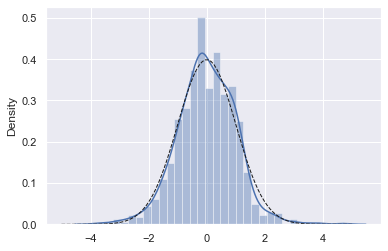

In [15]:
from scipy import stats
predict = model_a.predict()
resid = model_a.resid
rvs = stats.norm.pdf
x = np.linspace(-5,5,100)
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.distplot(resid)
ax1.plot(x, rvs(x), 'k--', lw=1)
## Shapiro–Wilk test
stats.shapiro(resid)

またQ–Qプロットと呼ばれる，理論上の正規分布における分位点と実際のデータの分位点を散布図としてプロットしたグラフで確認することもあります．Qは「Quantile」の略になります．statsmodels.apiにはqqplotというそのものズバリな関数が実装されています．

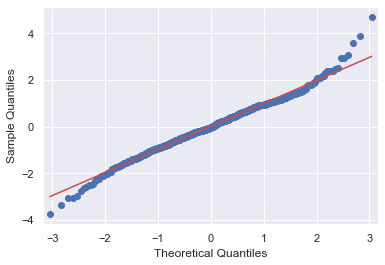

In [16]:
fig = sm.qqplot(resid, line='s')

残差は正規分布に従うと結論してよさそうです